In [117]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates

In [118]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [119]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [120]:
# Create Engine using 'hawaii.sqlite' database file
engine = create_engine('sqlite:///../src/hawaii.sqlite')

In [121]:
# Declare a Base using 'automap_base()'
Base = automap_base()

In [122]:
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [123]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [124]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [125]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [126]:
inspector = inspect(engine)
col_inspector = inspector.get_columns('measurement')
for column in col_inspector:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [127]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent)
type(recent)

# this returns a tuple

('2017-08-23',)


sqlalchemy.engine.row.Row

In [128]:
#Find the most recent date in the data set as a single value
recent2 = session.query(func.max(Measurement.date)).scalar()
print(recent2)
type(recent2)

2017-08-23


str

In [129]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
# Need to convert the queried dat from a string into a type usable by datetime 
# -- configured from in class activities
query_recent_date_str = session.query(func.max(Measurement.date)).scalar()

# year_ago_pd = query_recent_date_str - pd.DateOffset(years=1)
start_date = dt.datetime.strptime(query_recent_date_str,'%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
year_ago = start_date - dt.timedelta(days = 365)
print(f"Most recent date on file: {start_date}")
print(f"Precipitation range starts on: {year_ago}")

Most recent date on file: 2017-08-23
Precipitation range starts on: 2016-08-23


In [130]:
# Perform a query to retrieve the data and precipitation scores
precip_query = session.query(Measurement.station,
                             Measurement.date, 
                             Measurement.prcp).\
                    filter(Measurement.date >= year_ago).\
                    order_by(Measurement.date).\
                    all()
                                                               
# # Save the query results as a Pandas DataFrame. Explicitly set the column names
recent_year_precip = pd.DataFrame([(data.date, data.prcp) for data in precip_query]
                  , columns = ['Date', 'Precip']
                  )


# Sort the dataframe by date
recent_year_precip_sort = recent_year_precip.sort_values(['Date'])


In [131]:
# Convert ['Date'] from string to datetime
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
# https://stackoverflow.com/questions/45704366/how-to-change-the-datetime-tick-label-frequency-for-matplotlib-plots
# The second web address (stackoverflow) helped with dropping the hour/minute/second info after the datetime conversion

recent_year_precip_sort['Date'] = [pd.to_datetime(date, format = '%Y-%m-%d').date() for date in recent_year_precip_sort['Date']]


/var/folders/y9/z_8b8_4101z89mf3t6r1tf6m0000gn/T/ipykernel_3528/4058847457.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_label)


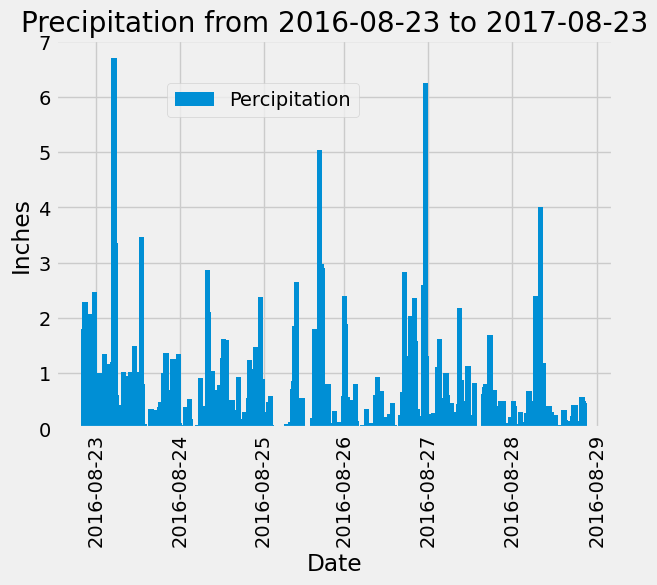

In [132]:
# Use Pandas Plotting with Matplotlib to plot the data

# Needed help with the date formatting: 
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/legend_demo.html
# https://matplotlib.org/stable/api/dates_api.html
# https://stackoverflow.com/questions/45704366/how-to-change-the-datetime-tick-label-frequency-for-matplotlib-plots



# plot data
x = recent_year_precip_sort['Date']
y = recent_year_precip_sort['Precip']
x_label = x.unique()

#plot type
ax = plt.subplot()
ax.bar(x,y
       ,width = 3.8
       ,label = 'Percipitation'
         )

# format x-axis
ax.set_xticklabels(x_label)
ax.tick_params(axis="x", rotation = 90)

# format legend, title, and axis labels
ax.legend(loc = (0.2,0.8), fancybox = True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title(f"Precipitation from {year_ago} to {start_date}")


plt.show()

In [133]:
# Use Pandas to calculate the summary statistics for the precipitation data
recent_year_precip_sort.describe()

,Precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [134]:
# Design a query to calculate the total number of stations in the dataset
query_station_count = session.query(Station).group_by(Station.station).count()
print(query_station_count)


9


In [135]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query_station_activity = session.query(Measurement.station,func.count()).\
                                    group_by(Measurement.station).\
                                    order_by(func.count().desc()).\
                                    all()                    
query_station_activity

# If you want to create pd DataFrame...

# station_activity = pd.DataFrame(query_station_activity, columns=['Station','Records'])
# station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [136]:
# recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

query_most_active_station =  session.query(Measurement.station,
                                           func.count()).\
                                    group_by(Measurement.station).\
                                    order_by(func.count().desc()).\
                                    first()   
most_active_station = query_most_active_station[0]
most_active_station

'USC00519281'

In [137]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_stats = session.query(func.min(Measurement.tobs),
                                    func.max(Measurement.tobs),
                                    func.avg(Measurement.tobs)).\
                                    filter(Measurement.station == most_active_station).all()

active_station_stats

[(54.0, 85.0, 71.66378066378067)]

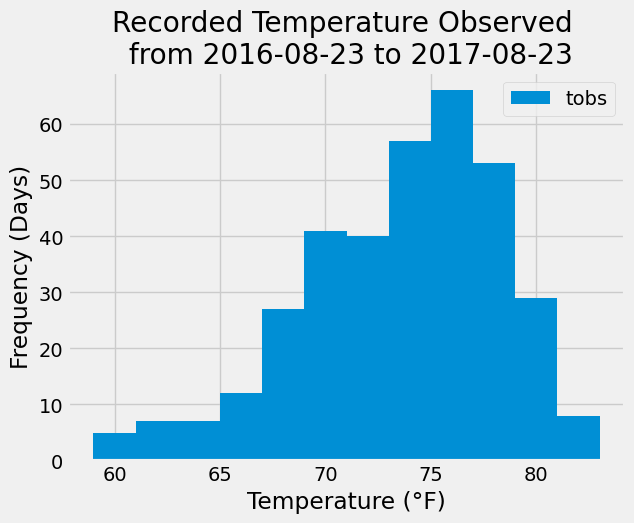

In [138]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

recent_tobs_result = session.query(Measurement.date,
                                    Measurement.tobs).\
                                filter(Measurement.station == most_active_station).\
                                filter(Measurement.date >=year_ago).\
                                order_by(Measurement.date).\
                                all()

# Organize data for upcomming plot
active_station_tobs_recent_year = [{'Date':result[0], 'Temperature': result[1]} for result in recent_tobs_result]
active_station_tobs_recent_year = pd.DataFrame(active_station_tobs_recent_year).set_index('Date')


# plot data
x = active_station_tobs_recent_year

# If the number of bins was to equal the number of unique temperature recordings/values
# n_bins = len(active_station_tobs_recent_year.groupby("Temperature").value_counts())

#plot type
ax = plt.subplot()

ax.hist(x, 
        bins = 12, 
        linewidth = 0.5
        )

# bins = 12 because temps are recorded per day, and each been represents a mounth of data
# ...though I think the # of bins should be the number of unique temps recorded

# format legend, title, and axis labels

# https://matplotlib.org/stable/gallery/statistics/hist.html#sphx-glr-gallery-statistics-hist-py
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html

ax.legend(['tobs'],loc = 'upper right', fancybox = True)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency (Days)')
plt.title(f"Recorded Temperature Observed \n from {year_ago} to {start_date}")


plt.show()


# Close Session

In [139]:
# Close Session
session.close()